I recently got familiar with the Apple ecosystem due to receiving a new iPhone from my mom. (Thanks, mom!)  I have had a MacBook Pro since college and now have an iPhone to seamlessly do tasks together. So watching Apple's latest WWDC 2024 was only the next best thing in order to keep track their newest offerings. 

Goal: NLP/Sentiment Analysis on WWDC 2024 - what people liked, what were the most talked about releases, etc.

Performing this analysis will provide insight on how Apple is still in the game since people have been seeing it as behind on the AI front.

In [1]:
!pip install praw duckdb jupysql bertopic groq pyabsa --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.11 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import os
from pprint import pprint

# math
from math import *
import math

# API's
import googleapiclient.discovery #YouTube
import googleapiclient.errors
import praw # Reddit
from praw.models import MoreComments
from kaggle_secrets import UserSecretsClient

# Data Manipulations
import re
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
from datetime import datetime 

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

# Visualization
import matplotlib.pyplot as plt 

# Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Topic Modeling
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

from sklearn.feature_extraction.text import CountVectorizer

# Fast Language Model Inference
from groq import Groq

# Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

# Named Entity Recognition
import spacy 
import requests 
from bs4 import BeautifulSoup
nlp = spacy.load("en_core_web_sm")
pd.set_option("display.max_rows", 200)

from spacy import displacy

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-07-09 20:41:29.596341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 20:41:29.596466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 20:41:29.780506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device
[2024-07-09 20:42:14] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






/opt/conda/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


# Get the data (YouTube and Reddit)
If there is not enough data, augment data with synonyms

API Links:
* [YouTube](https://console.cloud.google.com/apis/credentials?project=festive-zoo-404500)
* [Reddit](https://ssl.reddit.com/prefs/apps/)

YouTube Videos:
1. https://www.youtube.com/watch?v=qkYoBNdcXBU
1. https://www.youtube.com/watch?v=p2dhZ3AoDDs


Reddit Sub's:
1. https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/
1. https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/
1. https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/

In [3]:
user_secrets = UserSecretsClient()

In [4]:
# YouTube credentials
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = user_secrets.get_secret("youtube_apikey")

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [5]:
def getcomments(video):
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video,
        maxResults=100
    )

    comments = []

    response = request.execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            comment['textOriginal'],
            comment['videoId']
        ])

    while (1 == 1):
        try:
            nextPageToken = response['nextPageToken']
        except KeyError:
            break
        nextPageToken = response['nextPageToken']
        # Create a new request object with the next page token.
        nextRequest = youtube.commentThreads().list(part="snippet", videoId=video, maxResults=100, pageToken=nextPageToken)
        # Execute the next request.
        response = nextRequest.execute()
        # Get the comments from the next response.
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            published_at = comment['publishedAt']
            comments.append([
                comment['authorDisplayName'],
                published_at,
                comment['likeCount'],
                comment['textOriginal'],
                comment['videoId']
            ])

    df0 = pd.DataFrame(comments, columns = ['author', 'published_at', 'like_count', 'text', 'video_id'])
    return df0

In [6]:
# Get all WWDC 2024 comments from YouTube

# vids = [MKBHD, Vox]
vids = ["qkYoBNdcXBU", "p2dhZ3AoDDs"]

df0 = pd.DataFrame()

for v in vids:
    df1 = getcomments(v)
    df0 = pd.concat([df0, df1]) # Combine all df's together into one big dataframe

df0.sample(5)

author          published_at  like_count  \
7445               @BEnXAm.13  2024-06-11T09:38:50Z           1   
2658               @ma.fouani  2024-06-11T21:35:33Z           0   
927              @jimmyccfeng  2024-06-13T01:54:02Z           0   
2971                  @llama2  2024-06-11T19:54:22Z           0   
9406  @DinushaPavithraBandara  2024-06-11T07:38:52Z           1   

                                                                                                                                                                                                                                                                                  text  \
7445  As an android user, i confirme the app placing feature getting big applause was actually hilarious and made feel as a time traveler  🤣 . On the other hand , the hidden app folder to hide Tinder app from wife got me really interested 😇 ,MKBHD  went straight to the point 👏👏   
2658                                                                                                                                                                                                                             6:16 that's super weird! reminds the phonebooth movie   
927                                                                                                                                                                                                   I stopped paying attention after you mentioned MacOS was getting window snapping   
2971                                                                    So are all the Apple Intelligence features only for iPhone 15 pro, and all iPad and Mac with M chips? Is the regular 15 not even getting the new Siri? Or is the generative features only for the new devices.   
9406                                                                                                                                                                                                                                                         Pineapple intelligence 😎🍪   

         video_id  
7445  qkYoBNdcXBU  
2658  qkYoBNdcXBU  
927   qkYoBNdcXBU  
2971  qkYoBNdcXBU  
9406  qkYoBNdcXBU

In [7]:
# Proper date formats
df0['published_at'] = pd.to_datetime(df0['published_at'], format='%Y-%m-%dT%H:%M:%SZ')
df0['published_at_date'] = df0['published_at'].dt.date
df0['published_at_month'] = df0['published_at'].dt.month

In [8]:
# Rename video id's to appropriate video maker
df0['video_id'] = df0['video_id'].map({'qkYoBNdcXBU' : 'MKBHD', 'p2dhZ3AoDDs' : 'The Verge'})
df0.rename(columns = {'video_id':'youtube_channel'}, inplace=True)
df0.sample(5)

author        published_at  like_count  \
3180      @hamfield518 2024-06-11 19:02:24           0   
3623    @richardtosuto 2024-06-11 17:31:57           0   
8612   @hakanyucel1639 2024-06-11 08:15:08           0   
641            @ohaya1 2024-06-13 21:32:04           0   
5436  @faisalqadirabdu 2024-06-11 13:20:34           0   

                                                                                                                                                                                                                                                                     text  \
3180  They used apple intelegence to allow rearranging icons on the home screen, when this feature was literally availible on the 1984 macintosh! Only difference is, the homescreen was called a desktop back then, but wow now you can rearrange icons, no f*cking way!   
3623                                                                                                                                                                                                                                You mean, hide Grindr from your wife.   
8612                                                                                                                                                                                                            Goodbye Texas instrument and Casio! How need calculator 😂   
641                                                                                                                                                                                                                                             phone call summaries?????   
5436                                                                                                                                                                                                                   love the changing background styles in your videos   

     youtube_channel published_at_date  published_at_month  
3180           MKBHD        2024-06-11                   6  
3623           MKBHD        2024-06-11                   6  
8612           MKBHD        2024-06-11                   6  
641            MKBHD        2024-06-13                   6  
5436           MKBHD        2024-06-11                   6

In [9]:
df0['youtube_channel'].value_counts()

youtube_channel
MKBHD        9824
The Verge     483
Name: count, dtype: int64

In [10]:
df0['app'] = 'YouTube'

In [11]:
len(df0)

10307

In [12]:
# Reddit credentials
reddit = praw.Reddit(client_id=user_secrets.get_secret("reddit_client_id"),
                     client_secret=user_secrets.get_secret("reddit_client_secret"),
                     user_agent=user_secrets.get_secret("reddit_user_agent"))

In [13]:
# get all-level Reddit comments for all Reddit posts
def reddit_comments(url):

    all_level_comments = []

    submission = reddit.submission(url=url)

    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        published_at = str(datetime.fromtimestamp(comment.created)) #UTC
        published_at = pd.to_datetime(published_at, format='%Y-%m-%d %H:%M:%S')
        all_level_comments.append({
            "author": comment.author,
            "published_at": published_at, 
            "published_at_date": published_at.date(),
            "published_at_month": published_at.month,
            "like_count": comment.score,
            "text": comment.body
        })

    all_comments_df = pd.DataFrame(all_level_comments)
    return all_comments_df

In [14]:
# Define function to get dataframe for all Reddit comments
def combo_dataframe(links):
    df = pd.DataFrame()
   
    for l in links:
        df2 = reddit_comments(l)
        df = pd.concat([df, df2]) # Combine all df's together into one big dataframe
    return df

In [15]:
# get WWDC 2024 posts' all-level Reddit comments

reddit_links = ['https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/',
                 'https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/',
                 'https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/'] 

reddit_df = combo_dataframe(reddit_links)

In [16]:
reddit_df.head()

author        published_at published_at_date  \
0          BCDragon3000 2024-06-10 18:45:13        2024-06-10   
1            Oulixonder 2024-06-10 18:45:23        2024-06-10   
2       hammerheadtiger 2024-06-10 18:44:49        2024-06-10   
3  ConflictedRedbird186 2024-06-10 18:45:04        2024-06-10   
4       BeefIsForDinner 2024-06-10 18:44:24        2024-06-10   

   published_at_month  like_count  \
0                   6         816   
1                   6         526   
2                   6         876   
3                   6         134   
4                   6          91   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [17]:
len(reddit_df)

1344

In [18]:
reddit_df['app'] = 'Reddit'

In [19]:
# Before concating YouTube and Reddit df's. see if their columns are equal.
list(reddit_df)

['author',
 'published_at',
 'published_at_date',
 'published_at_month',
 'like_count',
 'text',
 'app']

In [20]:
youtube_df = df0.drop(columns=['youtube_channel'], inplace=True)
youtube_df = df0

In [21]:
list(youtube_df)

['author',
 'published_at',
 'like_count',
 'text',
 'published_at_date',
 'published_at_month',
 'app']

In [22]:
# Combine YouTube df and Reddit df together
df = pd.concat([youtube_df, reddit_df])
len(df)

11651

In [23]:
df.head()

author        published_at  like_count  \
0           @m4nc1n1 2024-07-09 20:19:06           0   
1       @JoshRWalker 2024-07-09 17:53:40           0   
2  @fallenlegion1828 2024-07-09 03:22:38           0   
3    @jared-paulcruz 2024-07-09 02:32:18           0   
4           @keeffe1 2024-07-08 20:48:36           0   

                                                                                                                                                                              text  \
0                                                                                                                                                                 You passed them!   
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.   
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      Yo marques is a logic fan?🎉   
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?   

  published_at_date  published_at_month      app  
0        2024-07-09                   7  YouTube  
1        2024-07-09                   7  YouTube  
2        2024-07-09                   7  YouTube  
3        2024-07-09                   7  YouTube  
4        2024-07-08                   7  YouTube

# With only 12,000 samples, augment data using synonyms?

# Perform Bertopic Modeling

In [24]:
# No text pre-processing needed
docs = df['text']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-07-09 20:43:29,926 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/365 [00:00<?, ?it/s]

2024-07-09 20:45:14,852 - BERTopic - Embedding - Completed ✓
2024-07-09 20:45:14,853 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-09 20:45:54,683 - BERTopic - Dimensionality - Completed ✓
2024-07-09 20:45:54,685 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-09 20:46:06,387 - BERTopic - Cluster - Completed ✓
2024-07-09 20:46:06,397 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-09 20:46:25,569 - BERTopic - Representation - Completed ✓


Topic  Count                                                Name  \
0       -1   2705                       -1_ai_features_samsung_google   
1        0    996                 0_calculator_ipad_handwriting_maths   
2        1    521                      1_apple_stock_windows_features   
3        2    458                2_siri_accessibility_typing_settings   
4        3    272                          3_icons_change_dark_colors   
5        4    255                          4_ai_tech_times_definition   
6        5    216                           5_15_pro_features_upgrade   
7        6    199                        6_ios_features_finally_years   
8        7    190                       7_ios18_beta_update_jailbreak   
9        8    179                              8_ipados_mac_remote_m4   
10       9    175                         9_cringe_genius_meme_insult   
11      10    173               10_intelligence_artificial_apple_term   
12      11    166                                 11_43_11_07_useless   
13      12    153                       12_privacy_data_cloud_compute   
14      13    147                     13_android_apple_users_features   
15      14    143                        14_tinder_grindr_wives_hides   
16      15    130                     15_lol_yaeeyyyyyyy_woooooot_11k   
17      16    122                    16_emojis_custom_robber_generate   
18      17    112                    17_ugly_design_customize_messing   
19      18    110                          18_15_pro_outdated_battery   
20      19    104                         19_samsung_wwdc_note_script   
21      20    102               20_mirroring_huawei_continuity_screen   
22      21     98                        21_pro_intelligence_m1_apple   
23      22     95                    22_lighting_grading_sunset_setup   
24      23     91               23_keynote_applause_audience_waveform   
25      24     79                         24_vr_announced_visionos_3d   
26      25     78                            25_openai_llm_elon_trust   
27      26     76             26_subscribers_youtube_presentations_1m   
28      27     74                  27_images_artists_generative_adobe   
29      28     72                      28_marques_samsung_notes_funny   
30      29     71               29_talking_galaxy_immature_contrarian   
31      30     68  30_scheduled_messages_jerryrigeverything_shortcuts   
32      31     67                      31_mkb_studio_thumbnails_night   
33      32     67                        32_s24_ultra_reading_updates   
34      33     67                      33_updates_releasing__ict_13th   
35      34     66                           34_ai_apple_compete_trust   
36      35     64                       35_song_intros_houdini_logics   
37      36     61                      36_android_drag_experience_wow   
38      37     60                    37_marques_pedro_brownlee_batman   
39      38     60                    38_lock_folder_flashlight_centre   
40      39     58                            39_db_bvg_bahn_transport   
41      40     57               40_brighter_esser_informative_watched   
42      41     57               41_chatgpt_gpt_integration_confirming   
43      42     55                            42_s24_bro_list_bragging   
44      43     55                      43_options_android_3gs_smaller   
45      44     55                          44_추구_korean_zipper_kislux   
46      45     54                         45_𝑡𝑜_chapters_apostasy_hii   
47      46     54                46_genmojis_excited_uncanny_stickers   
48      47     53                             47_chatgpt_4o_api_cloud   
49      48     52              48_upgrade_supported_generations_14pro   
50      49     51                           49_video_day_weve_hurtful   
51      50     51                    50_window_snapping_mac_rectangle   
52      51     50                      51_minutes_gang_renovating_260   
53      52     50                      52_satellite_sms_skynet_

* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.

Let's see if different embeddings create more clear topics.


In [25]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(df['text'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
df['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-07-09 20:47:11,171 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-09 20:47:21,856 - BERTopic - Dimensionality - Completed ✓
2024-07-09 20:47:21,858 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-09 20:47:29,552 - BERTopic - Cluster - Completed ✓
2024-07-09 20:47:29,560 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-09 20:47:45,362 - BERTopic - Representation - Completed ✓


CPU times: user 1min 43s, sys: 23.2 s, total: 2min 6s
Wall time: 1min 19s


Topic  Count                                                         Name  \
0      -1   4602                                     -1_apple_android_like_ai   
1       0    642                                    0_samsung_s24_ultra_notes   
2       1    570                            1_siri_accessibility_typing_voice   
3       2    446                                          2_15_iphone_ai_plus   
4       3    347                              3_icons_homescreen_widgets_ugly   
5       4    274                                    4_ai_tech_companies_times   
6       5    232                                5_calculator_app_notes_pencil   
7       6    227                           6_intelligence_apple_naming_called   
8       7    208                           7_underwhelming_joke_genmoji_hyped   
9       8    197                                  8_data_privacy_openai_cloud   
10      9    182                                   9_boring_apples_shill_yada   
11     10    163                              10_android_apple_copying_boomer   
12     11    158                                          11_ipad_m4_pro_need   
13     12    129                           12_emojis_custom_stickers_genmojis   
14     13    112                        13_mirroring_remote_vision_continuity   
15     14     86                                 14_tinder_grindr_hides_mkbhd   
16     15     83                                 15_intros_logics_eminem_fear   
17     16     82                    16_calculator_photomath_students_cringest   
18     17     82  17_backgraund_这就是中国全部手机公司市值的科技公司所做出来的创新_goobyeprivacy_hakka   
19     18     78                             18_physics_insane_maths_students   
20     19     77                               19_2016_xiaomi_bootloaders_iso   
21     20     75                                 20_musk_openai_banning_wahhh   
22     21     74                               21_calculator_app_combines_cal   
23     22     71                          22_lighting_grading_cinematic_hotel   
24     23     69                                    23_ai_apple_sounds_naming   
25     24     68                             24_window_snapping_mac_rectangle   
26     25     60                                  25_neat_dope_legend_watchin   
27     26     59                             26_jailbreak_cydia_tweaks_themes   
28     27     57                                        27_beta_dev_pjpg_redd   
29     28     55                              28_math_notes_calculator_solver   
30     29     54                                   29_mkbhd_tweet_prime_elons   
31     30     53                          30_ios_closer_discrimination_10year   
32     31     53                             31_trademark_apple_train_develop   
33     32     52                                          32_db_bvg_bahn_apps   
34     33     51                              33_recording_pause_calls_forgot   
35     34     49                                 34_marques_batman_mark_reads   
36     35     49                          35_video_brother_informative_kislux   
37     36     49                             36_lighting_studio_rooms_manages   
38     37     47                              37_passwords_app_icloud_spotify   
39     38     45                                38_garmin_rings_tracking_pace   
40     39     44                             39_wwdc_keynote_severance_season   
41     40     42                        40_images_artists_generate_generative   
42     41     42                         41_vision_announced_expensive_wwdc23   
43     42     41                                          42_ram_tops_gpu_a16   
44     43     40                            43_texts_messages_formatting_wake   
45     44     40                             44_deleted_appearing_suddenly_27   
46     45     39                                45_rcs_mentioned_adds_support   
47     46     38                                46_yt_comments_playlist_title   
48     47     38                   

In [26]:
topic_model.get_topic(0) # top topic

[('samsung', 0.10439102122120315),
 ('s24', 0.05561324623153782),
 ('ultra', 0.05296832143814461),
 ('notes', 0.04028891130369922),
 ('marques', 0.031935103641689784),
 ('read', 0.03168402811241626),
 ('mkbhd', 0.030768363188334),
 ('updates', 0.01974812403519104),
 ('funny', 0.015365647886105647),
 ('ios', 0.014563219638258297)]

These topics seem more interpretable due to better embeddings.

#### BERTopic Visualizations 
Reference: https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-probablities-or-distribution

In [27]:
topic_model.visualize_topics()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The biggest topic after the outlier topic (0) was topic 1 which was about Siri. I used the slider to highlight the bubble. When you hover over the bubble, you see the words associated with the topic.

In [28]:
topic_model.visualize_barchart(top_n_topics=8)

Looks like some other huge topics were criticism of Apple being behind in development including the AI frontier. Though a huge win was the showcasing of the interactive/predictive calculator.

In [29]:
topic_model.visualize_heatmap()

# Perform Sentiment and Emotion Classification

* Not sure what the benchmark is for good separation between topics. 
* Considering topics not along the diagonal and not associated with topic 0.  
* Most topics are 0.4 or below in similarity score. This means there are nice distinct topics discovered under better embeddings and BERTopic model.

In [30]:
# using Hugging Face sentiment classifier trained on pre-trained on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

I need to take care of long comments. Will use an LLM to summarize down to the necessary amount of sentences. Will need to use a Tokenizer to determine max sentences for summary cut-off.

Using cased model so case-sentitive text used to train model. so for inference, no need for lowering text

In [31]:
# Need to make comments text as similar as it was for model training for sentiment inference: remove HTML tags
# Need to also get rid of weird tags since model was not trained on that for inference

def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', ' ').replace('\t', '')
    
df['processed_text'] = df.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
df.head(5)

author        published_at  like_count  \
0           @m4nc1n1 2024-07-09 20:19:06           0   
1       @JoshRWalker 2024-07-09 17:53:40           0   
2  @fallenlegion1828 2024-07-09 03:22:38           0   
3    @jared-paulcruz 2024-07-09 02:32:18           0   
4           @keeffe1 2024-07-08 20:48:36           0   

                                                                                                                                                                              text  \
0                                                                                                                                                                 You passed them!   
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.   
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      Yo marques is a logic fan?🎉   
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?   

  published_at_date  published_at_month      app  \
0        2024-07-09                   7  YouTube   
1        2024-07-09                   7  YouTube   
2        2024-07-09                   7  YouTube   
3        2024-07-09                   7  YouTube   
4        2024-07-08                   7  YouTube   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           use4  \
0  [-0.023736493661999702, -0.05002313107252

In [32]:
# %%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. 
# Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 450 total words as max total words per comments since tokenizer can add suffixes as a token
#2. eliminate token lengths greater than max/SUMMARIZE comments using Grok since losing richness of dataset with eliminating comments

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

df['num_tokens'] = df.apply(lambda row: len(tokenizer.tokenize(row.processed_text)), axis = 1)
df.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


author        published_at  like_count  \
0           @m4nc1n1 2024-07-09 20:19:06           0   
1       @JoshRWalker 2024-07-09 17:53:40           0   
2  @fallenlegion1828 2024-07-09 03:22:38           0   
3    @jared-paulcruz 2024-07-09 02:32:18           0   
4           @keeffe1 2024-07-08 20:48:36           0   

                                                                                                                                                                              text  \
0                                                                                                                                                                 You passed them!   
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.   
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      Yo marques is a logic fan?🎉   
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?   

  published_at_date  published_at_month      app  \
0        2024-07-09                   7  YouTube   
1        2024-07-09                   7  YouTube   
2        2024-07-09                   7  YouTube   
3        2024-07-09                   7  YouTube   
4        2024-07-08                   7  YouTube   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           use4  \
0  [-0.023736493661999702, -0.05002313107252

In [33]:
# Now let us take a look at comments composition that have the highest token length

query = """
select author
, num_tokens
, processed_text
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

466 is the number of tokens closest to 450 and still exceeding it. Let's take a look at the number of sentences that these comments are comprised of in order to get a total sentence target for summarization.

In [34]:
# Sentence Count
df['sent_count'] = df['processed_text'].str.count('[\w][\.!\?]')

<>:2: DeprecationWarning:

invalid escape sequence '\w'



In [35]:
query = """
select author
, num_tokens
, processed_text
, sent_count
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Try to use open source LLM/Fast Language Model (groqcloud) to summarize Pandas text column
Reference: https://console.groq.com/docs/quickstart

In [36]:
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
            Here is the original comment:
            i want to thank you for always giving us a well thought videos. others spend time babbling and trying to be funny and you sound like a tech guy giving us tech news. i have a suggestion to take you to a new level. i have been writing apple for years. i honestly believe they have used some of my ideas. i’ll share them in a moment. by the way i am a software engineer. i am not one who thinks i am so d smart or the smarted person in the room. i love to always learn and ai find i am always learning new things from you. so my idea for you is a real tech news channel. this will make you something like the wal mart of tech news. this idea could put some tech influencers out of business with this idea. i tried to float this to apple but they don’t seem to like the idea. we have cnn, nbc news, abc news, cbs news and from time to time we get tech news but mostly when something new like a new iphone is released. tech news is happening every day all day. i say join forces with some of the best like yourself, brian tong, possibly some from engadget and create a real tech news channel. it’s not based around politics although t today politics and tech seem to collide. evs and republicans wanting to k evs, tictok, twitter. with social media companies being as influential as they have become. they’re not on the hot seat enough with cameras in their face or reporters running up on them to ask difficult questions. a real tech news channel will do this. what you and others do is journalism. i want the news to still be fun but i want it just like real news every day 24/7 just like a cnn. you will hire anchors do some in-depth interviews like we see you do often with tech ceo’s. it’s a militia billion. dollar idea i am giving to you. this is something new of its kind and needed. tech is no longer just mobile. we have stepped into the world of ai and humans need to understand how these new pieces of tech will i pack them. i would love to work with you as a producer or something. i have a huge idea and it will work.	31
            
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

"Here's a condensed version of the original comment:\n\nI want to express my appreciation for your well-researched and informative tech videos. I think your approach sets you apart from other tech content creators. As a software engineer with years of experience, I've had some ideas that I believe Apple has used. I'd love to share those ideas with you.\n\nI think you have the potential to take your content to the next level by creating a 24/7 tech news channel, like a CNN or NBC News, but focused specifically on tech. This channel could feature in-depth interviews with tech CEOs and journalists, as well as daily coverage of tech news. It's an idea that could disrupt the industry and make you a household name.\n\nThe idea is not just about tech news, but also about exploring the intersection of tech and politics. With the increasing influence of social media companies, it's essential to hold them accountable through in-depth reporting and tough questions.\n\nAs someone who is passionate

In [37]:
# Exclude chat bot intro portion as whole inference
spl_word = '\n\n'
res = chat_completion.choices[0].message.content.split(spl_word, 1)
res[0]

"Here's a condensed version of the original comment:"

In [38]:
#Let's check if this condensed version from Groq is <512/450 tokens in length
len(tokenizer.tokenize(res[0]))

11

* [x] Now write up a function in order to loop through Pandas text column that has >450 tokens 
* [x] Put responses in a list
* [x] Add summaries to df 
* [x] Now run tokenizer
* [x] Check to make sure that each row now has 500 or less tokens
* After verification, perform sentiment and emotion analysis possibly using HF and Groq

In [39]:
query = """
select *
from df
where num_tokens >450
"""

summarize_df = duckdb.query(query).df()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [40]:
condensed = []
for text in summarize_df['processed_text']:
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": '''

                Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
                Here is the original comment:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    spl_word = '\n\n'
    res = chat_completion.choices[0].message.content.split(spl_word, 1)
    condensed.append(res[1])

In [41]:
condensed[1]

"The WWDC iPad calculator app, praised by MKBHD, is just a gimmick. The features, such as giving answers as you write down a math question, adjusting numbers, and adding graphs, are impressive but useless in real-world context. The app targets students, but its features are limited to primary school level. Beyond 4th grade, students need to manipulate equations and find x, which the app can't handle. Physical calculators are faster, easier, and more representative of exam conditions. The iPad calculator is inferior to a physical calculator like the TI-Nspire, which has more features and is more powerful. The app's features can be easily replicated using free software like Geogebra and Desmos. There's no need to spend $1000 on an iPad to access these features. The app's cool factor comes from novelty, not its practical application. In the future, we should reflect on how features would be translated to real-world use, rather than blindly following hype. The Samsung AI features on my Z F

In [42]:
summarize_df['processed_text'][1]

"My take on WWDC's iPad calculator app: It's nothing more than a gimmick WWDC just dropped yesterday and one of the highlight features was the calculator app feature. MKBHD, the gold standard reviewer to go to when it comes to technology, called it the only “incredible feature” that came to the iPad. But like almost every other hyped software/AI update these days, they hardly get used by us in the real world. Ok, let’s dive into the main Math Notes features that everyone is so excited about and I will explain why they are all useless gimmicks: It’s able to give you answers as you write down a maths question. You can adjust the information in your math question and the answer will update accordingly. It can support variables and equations, and you can manipulate them all you want. You can add graphs in the notes and demonstrate the function as you manipulate the numbers. The features listed above are pretty cool, but if we were to put them in a real-world context, they instantly become 

Very nice condensed version of >500 token comment. Now let us combine the two lists into two Pandas columns. And then join this to the original df on the non-condensed. And finally, create a new column that has >=500 tokens non-condensed and condensed text.

In [43]:
summarize_df['condensed_text'] = condensed

In [44]:
# Compare/Check original comment to condensed versions

query = """
select processed_text
, condensed_text
from summarize_df
"""
sum_df = duckdb.query(query).df()
sum_df

processed_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [45]:
df.tail(1)

author        published_at  like_count  \
315  Outlulz 2024-06-12 17:56:48           1   

                                                                                                                                 text  \
315  And they underestimate how much those power users need apps that aren't feature limited in various ways, as iPad apps often are.   

    published_at_date  published_at_month     app  \
315        2024-06-12                   6  Reddit   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            use4  \
315  [0.03637425974011421, 0.0018887761980295181, 0.013794836588203907, -0.024645013734698296, 0.07509669661521912, 0.029787365347146988, -0.01466673705726862, 0.02737506851553917, -0.08639978617429733, -0.021323829889297485, -0.02128777652978897, 0.026287969201803207, 0.01025031041353941, 0.0193417277187109, -0.08800722658634186, 0.08082183450460434, 0.056345097720623016, 0.07507497817277908, -0.007823891006410122, -0.019303735345602036, 0.000409406959079206, -0.01521315984427929, -0.036233916878700256, -0.05661900341510773, 0.02512439340353012, 0.08912590146064758, -0.05415946990251541, -0.045390866696834564, -0.03022334724664688, -0.007936893962323666, -0.06654815375804901, 0.03164668381214142, -0.012801420874893665, 0.0017923107370734215, -0.017152199521660805, -0.030316205695271492, 0.020496021956205368, -0.010173254646360874, -0.009121441282331944, -0.0070608993992209435, 0.08494159579277039, 0.06523647159337997, 0.0520232655107975, 0.0027275464963167906, 0.07034623622894287, 0.05289117991924286, 0.02846478298306465, -0.0030938787385821342, 0.021142514422535896, -0.022366231307387352, -0.05657031387090683, -0.021899281069636345, 0.014888428151607513, 0.01524202711880207, -0.08869250863790512, 0.04491351172327995, -0.032583288848400116, 0.01595481112599373, -0.013498134911060333, 0.0032672

In [46]:
# Combine summarized df back to original

query = """
select author
, like_count
, text as original_text
, published_at_date
, app
, t1.processed_text
, condensed_text
from (select * exclude (published_at, published_at_month, use4, num_tokens, sent_count)
from df) t1
left join sum_df
on t1.processed_text = sum_df.processed_text

"""
summarized_df = duckdb.query(query).df()
summarized_df.head()

author  like_count  \
0           @m4nc1n1           0   
1       @JoshRWalker           0   
2  @fallenlegion1828           0   
3    @jared-paulcruz           0   
4           @keeffe1           0   

                                                                                                                                                                     original_text  \
0                                                                                                                                                                 You passed them!   
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.   
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      Yo marques is a logic fan?🎉   
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?   

  published_at_date      app  \
0        2024-07-09  YouTube   
1        2024-07-09  YouTube   
2        2024-07-09  YouTube   
3        2024-07-09  YouTube   
4        2024-07-08  YouTube   

                                                                                                                                                                    processed_text  \
0                                                                                                                                                                 You passed them!   
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.   
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      Yo marques is a logic fan?🎉   
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?   

  condensed_text  
0           None  
1           None  
2           None  
3           None  
4           None

In [47]:
len(summarized_df)

11651

In [48]:
summarized_df.head(1)

author  like_count     original_text published_at_date      app  \
0  @m4nc1n1           0  You passed them!        2024-07-09  YouTube   

     processed_text condensed_text  
0  You passed them!           None

In [49]:
# Create one column without NaN (coalesce) and eliminate extraneous columns before sentiment/emotion classification
# Compare/Check original comment to condensed versions

query = """
select author
, like_count
, original_text
, published_at_date
, app
, case when condensed_text IS NULL then processed_text else condensed_text end as final_text
from summarized_df
"""
inf_df = duckdb.query(query).df()
inf_df['final_text'] = inf_df.apply(lambda row: cleanhtml(row['final_text']), axis=1)
inf_df.head(5)

author  like_count  \
0           @m4nc1n1           0   
1       @JoshRWalker           0   
2  @fallenlegion1828           0   
3    @jared-paulcruz           0   
4           @keeffe1           0   

                                                                                                                                                                     original_text  \
0                                                                                                                                                                 You passed them!   
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.   
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      Yo marques is a logic fan?🎉   
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?   

  published_at_date      app  \
0        2024-07-09  YouTube   
1        2024-07-09  YouTube   
2        2024-07-09  YouTube   
3        2024-07-09  YouTube   
4        2024-07-08  YouTube   

                                                                                                                                                                        final_text  
0                                                                                                                                                                 You passed them!  
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.  
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao  
3                                                                                                                                                      Yo marques is a logic fan?🎉  
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?

In [50]:
inf_df.isnull().sum()

author               44
like_count            0
original_text         0
published_at_date     0
app                   0
final_text            0
dtype: int64

In [51]:
len(summarize_df)

10

In [52]:
query = """
select *
from inf_df
where author in (select author from summarize_df)
"""
duckdb.query(query).df()

author  like_count  \
0   @madboyreadynow28           0   
1     hammerheadtiger          99   
2     hammerheadtiger          11   
3     hammerheadtiger           5   
4        KLM_SpitFire           2   
5    @johnpearson1258           0   
6       @flowting5163           0   
7          @lellmajar           0   
8          @ThuanSuBa           0   
9   @madboyreadynow28           0   
10      @mndlessdrwer           0   
11      @hilal_younus           2   
12    hammerheadtiger         876   
13       KLM_SpitFire           2   
14           kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Great. /n is removed from text grabbed via API. Now let us re-tokenize the text to make sure we don't hit an error. 

In [53]:
inf_df['num_tokens'] = inf_df.apply(lambda row: len(tokenizer.tokenize(row.final_text)), axis = 1)

In [54]:
query = """
select max(num_tokens)
from inf_df
"""
duckdb.query(query).df()

max(num_tokens)
0              446

In [55]:
# The sentiment classifier still had some comments that exceeded 512 tokens. So need to eliminate more comments...
query = """
select *
from inf_df
where num_tokens <=450
"""
inf_df2 = duckdb.query(query).df()

In [56]:
inf_df.drop(columns=['num_tokens'], inplace=True)
inf_df.head(1)

author  like_count     original_text published_at_date      app  \
0  @m4nc1n1           0  You passed them!        2024-07-09  YouTube   

         final_text  
0  You passed them!

Great! Let us now get sentiment and emotion classifications.

In [57]:
len(inf_df)-len(inf_df2) # difference is small. so proceed.

0

## Sentiment Classification

In [58]:
%%time

inf_df2 = (
inf_df2.assign(sentiment = lambda x: x['final_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

inf_df2.head()

CPU times: user 17min 13s, sys: 3.09 s, total: 17min 16s
Wall time: 8min 38s


author  like_count  \
0           @m4nc1n1           0   
1       @JoshRWalker           0   
2  @fallenlegion1828           0   
3    @jared-paulcruz           0   
4           @keeffe1           0   

                                                                                                                                                                     original_text  \
0                                                                                                                                                                 You passed them!   
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.   
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      Yo marques is a logic fan?🎉   
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?   

  published_at_date      app  \
0        2024-07-09  YouTube   
1        2024-07-09  YouTube   
2        2024-07-09  YouTube   
3        2024-07-09  YouTube   
4        2024-07-08  YouTube   

                                                                                                                                                                        final_text  \
0                                                                                                                                                                 You passed them!   
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.   
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      Yo marques is a logic fan?🎉   
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?   

   num_tokens                                             sentiment     label  \
0           4  [{'label': 'positive', 'score': 0.6176588535308838}]  positive   
1          39  [{'label': 'negative', 'score': 0.5983965992927551}]  negative   
2          18  [{'label': 'negative', 'score': 0.4405288100242615}]  negative   
3           9  [{'label': 'positive', 'score': 0.3599625825881958}]  positive   
4          13   [{'label': 'negative', 'score': 0.458789199590683}]  negative   

      score  
0  0.617659  
1  0.598397  
2  0.440529  
3  0.359963  
4  0.458789

In [59]:
inf_df2.tail(5)

author  like_count  \
11646    @mndlessdrwer           0   
11647    @hilal_younus           2   
11648  hammerheadtiger         876   
11649     KLM_SpitFire           2   
11650         kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

<Axes: >

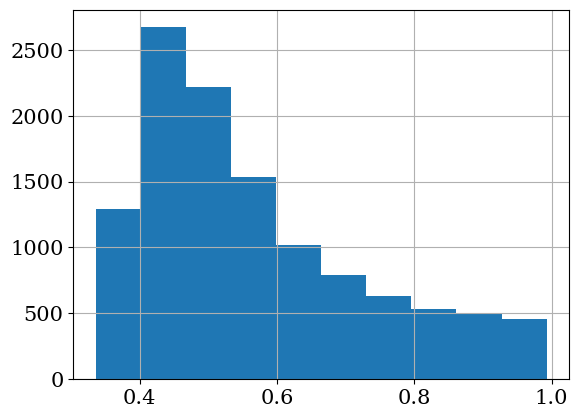

In [60]:
# From my own review, the sentiment classifier is not that accurate. Let's take a look at the score distribution to see confidence distribution.
inf_df2['score'].hist()

We can see here that the model is less than 50% sure on majority of its sentiment guess. This is not good and has to do with the data that it was trained on, how different it is from the data that it is predicting on now. Let us try to see grok's sentiment accuracy.

In [61]:
query = """
select author
, like_count
, original_text
, published_at_date
, app
, final_text
, label as hf_sentiment
, score as hf_score
from inf_df2
"""
inf_df2 = duckdb.query(query).df()

In [62]:
inf_df2.head(1)

author  like_count     original_text published_at_date      app  \
0  @m4nc1n1           0  You passed them!        2024-07-09  YouTube   

         final_text hf_sentiment  hf_score  
0  You passed them!     positive  0.617659

__________
# Attempt to use Groq as sentiment classifier starts here.

In [63]:
# Need to chunk df into 100 rows at a time and feed into groq
list_df = np.array_split(inf_df2, math.ceil(len(inf_df2)/100))

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [64]:
%%time

#Checking to see if for loop without fxn works
groq_sentiment = [] # to store predictions
for text in list_df[0]['final_text']: #using one chunk of 100 rows only, looping through text fed into model
    chat_completion = client.chat.completions.create( #task performed on each comment
        messages=[
            {
                "role": "user",
                "content": '''

                Please classify the following comment with a sentument: negative, neutral or positive as well as output the confidence score as a percentage. Output only the sentiment and score as a python dictionary inside a list in consistent format. For example only return: [{'sentiment': sentiment prediction, 'score': score percentage}].
                This is the comment to classify sentiment on:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    res = chat_completion.choices[0].message.content
#     spl_word = '\n\n' #Trying to sanitize groq model re before adding to df
#     res = chat_completion.choices[0].message.content.split(spl_word, 1)
#     clean_res = re.findall(r'"([^"]*)"', res)

    groq_sentiment.append(res) #adding prediction to list to eventually append to df

CPU times: user 1.04 s, sys: 66.8 ms, total: 1.1 s
Wall time: 3min 6s


In [65]:
groq_sentiment[:10]

["Here is the sentiment classification for the comment:\n\n[{'sentiment': 'positive', 'score': 92.45}]",
 "Here is the sentiment classification and confidence score:\n\n[{'sentiment': 'positive', 'score': 92.5}]",
 "Here is the output:\n\n[{'sentiment': 'positive', 'score': 92.0}]",
 "Here is the sentiment classification output:\n\n[{'sentiment': 'positive', 'score': 83.33}]",
 "Here is the sentiment classification for the given comment:\n\n[{'sentiment': 'positive', 'score': 83.33}]",
 "Here is the classification result:\n\n [{'sentiment': 'neutral', 'score': 71.4}]\n\nNote: The score is the confidence percentage for the sentiment classification, which in this case is 71.4%. The sentimental analysis is neutral, indicating that the comment does not have a strong emotional tone, neither positive nor negative.",
 "Here is the sentiment analysis output:\n\n[{'sentiment': 'negative', 'score': 82.0}]\n\nNote that this model is trained on a large dataset of text samples, and while it's not p

In [66]:
list_df[0]['final_text'][:10]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [67]:
# fxn framework

# def groq_pred (df):
#     groq_sentiment = []
#     for text in df['final_text']:
#         something
#     return final

In [68]:
# %%time

# Trying to add function to proven for loop through df['final_text']
# all_pred = []

# for sub_df in list_df[0]:
#     all_pred.append(groq_pred(sub_df))

In [69]:
# Make all predictions from chunks into one big list to add to original inf_df2

# flattened_list = list(itertools.chain(*all_pred))
# flattened_list[:2].head(5)

________

## Emotion Classification

In [70]:
# Need to lower text for inference since emotion model trained on uncased text
inf_df2['final_text'] = inf_df2['final_text'].str.lower()

In [71]:
%%time

# Info pg: https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion

# Set up the inference pipeline using a model from the 🤗 Hub

emotion_model = pipeline(model="bhadresh-savani/distilbert-base-uncased-emotion")
inf_df2= (
inf_df2.assign(emotion1 = lambda x: x['final_text'].apply(lambda s: emotion_model(s)))
    .assign(
         hf_emotion = lambda x: x['emotion1'].apply(lambda s: (s[0]['label']))
    )
)

inf_df2.drop(columns=['emotion1'], inplace=True)
inf_df2.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

CPU times: user 16min 48s, sys: 3.86 s, total: 16min 52s
Wall time: 8min 29s


author  like_count  \
0           @m4nc1n1           0   
1       @JoshRWalker           0   
2  @fallenlegion1828           0   
3    @jared-paulcruz           0   
4           @keeffe1           0   

                                                                                                                                                                     original_text  \
0                                                                                                                                                                 You passed them!   
1  They are resolving the tension that I've had internally with my phone over the years. There is finally a new world of things I can depend on the device in my pocket to do now.   
2                                                                                                              I didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      Yo marques is a logic fan?🎉   
4                                                                                                                   Who else felt this AI stuff was directed at a certain someone?   

  published_at_date      app  \
0        2024-07-09  YouTube   
1        2024-07-09  YouTube   
2        2024-07-09  YouTube   
3        2024-07-09  YouTube   
4        2024-07-08  YouTube   

                                                                                                                                                                        final_text  \
0                                                                                                                                                                 you passed them!   
1  they are resolving the tension that i've had internally with my phone over the years. there is finally a new world of things i can depend on the device in my pocket to do now.   
2                                                                                                              i didnt know you couldnt customize your home screen on iphone lmfao   
3                                                                                                                                                      yo marques is a logic fan?🎉   
4                                                                                                                   who else felt this ai stuff was directed at a certain someone?   

  hf_sentiment  hf_score hf_emotion  
0     positive  0.617659      anger  
1     negative  0.598397        joy  
2     negative  0.440529        joy  
3     positive  0.359963      anger  
4     negative  0.458789       fear

### Emotion classifier is somewhat off, but does help augment sentiment classification when both agree and are right in sentiment.

## Sentiment and Emotion over Time

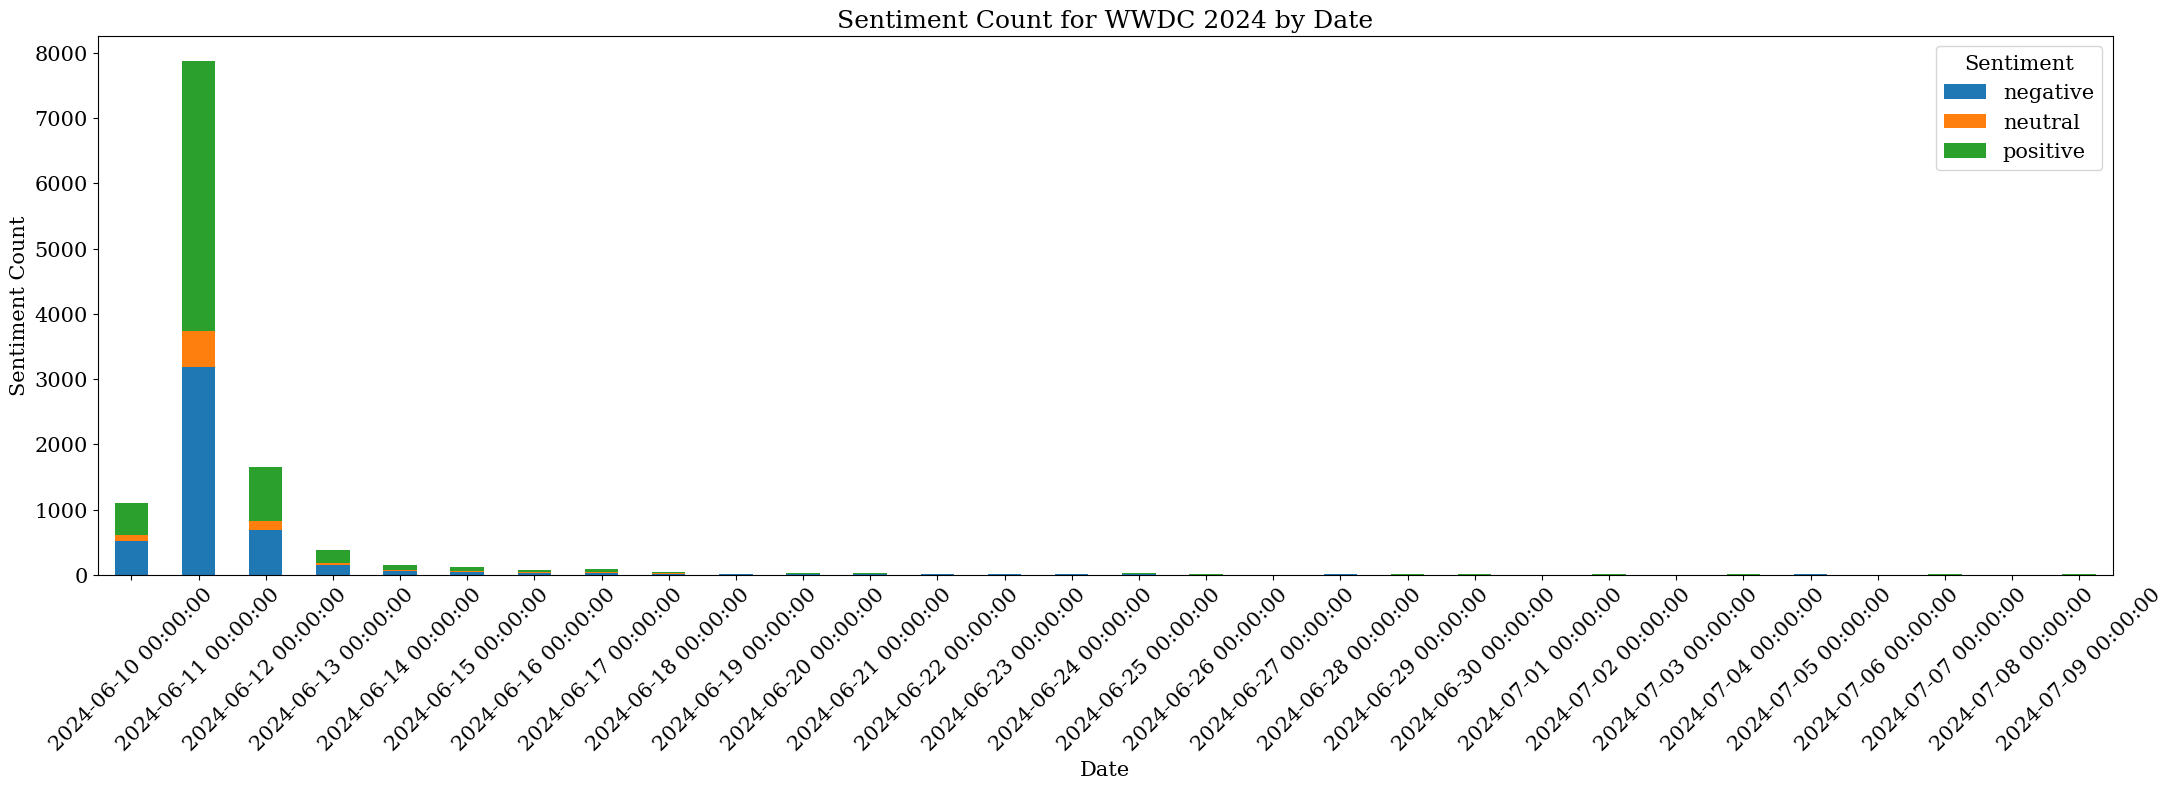

In [72]:
# For YouTube and Reddit users

# Group by hf_sent_label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_sentiment', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_sentiment', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Sentiment Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

Most comments made on 6.11.24 and there is almost a split in sentiment between positive and negative. Let's take a look at the emotion breakdown. Mostly positive across days.

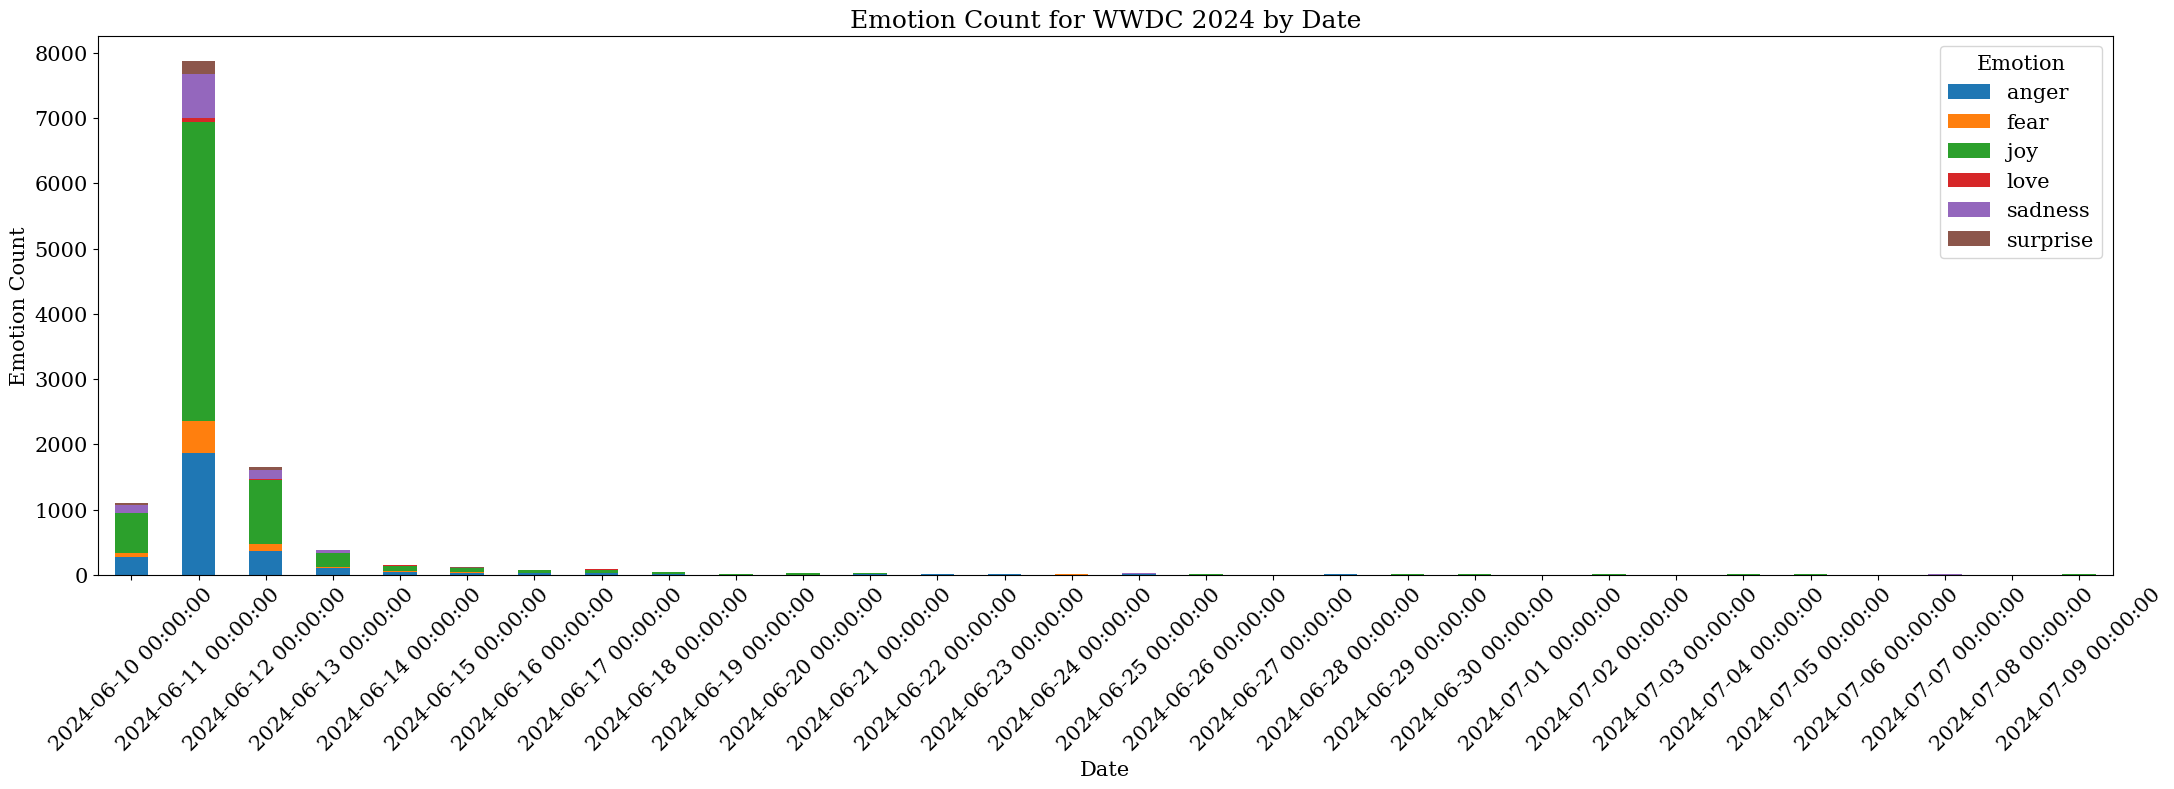

In [73]:
# Group by hf_sent_label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_emotion', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_emotion', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Emotion Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Emotion Count')
plt.xticks(rotation=45)
plt.legend(title='Emotion')
plt.show()

With emotion breakdown, we see surprise and joy making up the positive sentiment and anger making up most of the negative sentiment. Mostly joy across days.

# Aspect Based Sentiment Analysis (ASBA) Using PyABSA

In [74]:
# Trying to get more granular with sentiment analysis. E.g. What particular features lead to joy/anger?

aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

[2024-07-09 21:08:55] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-09 21:08:55] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-09 21:08:55] (2.4.1.post1) Downloading checkpoint:english 
[2024-07-09 21:08:55] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


Done.
[2024-07-09 21:09:06] (2.4.1.post1) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2024-07-09 21:09:06] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-07-09 21:09:06] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-07-09 21:09:06] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2024-07-09 21:09:06] (2.4.1.post1) model: None
[2024-07-09 21:09:06] (2.4.1.post1) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2024-07-09 2

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



In [75]:
# Let us try HuggingFace model

# model_name = "yangheng/deberta-v3-large-absa-v1.1"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [76]:
# Can pre-define aspects and see what the sentiment in text was. E.g.

# aspects = ["food", "service", "ambience"]

# text = """
# the service was absolutely horrible. 
# the restaurant was not very busy, and yet we waited over 1 hour for our food. 
# would not recommend if you are expecting good service. 
# additionally, the food was very sub par. the draft beer was flat, 
# and the other drinks were nothing special. 
# would advise elsewhere for mexican food.
# """
# d = {}
# for aspect in aspects:
#     d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
# d

In [77]:
# just pick a sample from df to perform general aspect-based sentiment analysis to see its performance
inf_df2_percent = inf_df2.sample(frac=0.01)
inf_df2_percent = inf_df2_percent.reset_index(drop=True)

In [78]:
len(inf_df2_percent)

117

In [79]:
# aspects = ["OS", "hardware", "developer tools", "software features and apps", 
#            "privacy and security", "services", "augmented reality and virtual reality",
#           "health and fitness", "sustainability", "surprises and innovation"]

# def absa_general(text):

#     d = {}
#     for aspect in aspects:
#         d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
#     return d

# inf_df2_percent['absa_gen'] = inf_df2_percent.apply(lambda row: absa_general(row['final_text']), axis=1)

In [80]:
# # Extract keys and create new columns
# for key in inf_df2_percent['absa_gen'][0].keys():
#     inf_df2_percent[key] = inf_df2_percent['absa_gen'].apply(lambda x: x[key])

# # Display the updated DataFrame
# inf_df2_percent

In [81]:
# # Extract keys and create new columns
# for key in inf_df2_percent['absa_gen'][0].keys():
#     inf_df2_percent[key] = inf_df2_percent['absa_gen'].apply(lambda x: x[key])

# # Count occurrences of each sentiment for food, service, and ambience
# sentiments = ['Positive', 'Neutral', 'Negative']
# aspects = ["OS", "hardware", "developer tools", "software features and apps", 
#            "privacy and security", "services", "augmented reality and virtual reality",
#           "health and fitness", "sustainability", "surprises and innovation"]

# # Initialize an empty dictionary to hold the sentiment counts
# sentiment_counts = {aspect: {sentiment: 0 for sentiment in sentiments} for aspect in aspects}

# # Populate the sentiment counts
# for aspect in aspects:
#     counts = inf_df2_percent[aspect].value_counts()
#     for sentiment in sentiments:
#         if sentiment in counts:
#             sentiment_counts[aspect][sentiment] = counts[sentiment]

# # Create a DataFrame from sentiment counts
# sentiment_df = pd.DataFrame(sentiment_counts)

# # Plot the stacked bar chart
# sentiment_df.T.plot(kind='bar', stacked=True)

# # Customize the chart
# plt.title('WWWDC Sentiment Breakdown for Aspects')
# plt.xlabel('Aspect')
# plt.ylabel('Count of Sentiments')
# plt.xticks(rotation=45)

# # Place the legend outside the plot
# plt.legend(title='Sentiment Key', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Adjust the layout to make room for the legend
# plt.tight_layout()

# # Show the plot
# plt.show()

In [82]:
%%time

# Make sure new dict created with aspects and sentiments
def absa_sp(text):

    atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )
    aspect = atepc_result[0].get('aspect')
    sentiment = atepc_result[0].get('sentiment')
    new_dict = dict(zip(sentiment, aspect)) #swap this to use chatgpt 3.5/try gemini
    
    grouped_dict = {} # Create final dictionary that aggregates words to grouped by sentiment

    for key, value in new_dict.items():
        if value not in grouped_dict:
            grouped_dict[value] = [key]
        else:
            grouped_dict[value].append(key)

    # Convert keys into combined strings
    grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}
    
    return grouped_dict


inf_df2_percent['absa_sp'] = inf_df2_percent['final_text'].apply(lambda x: absa_sp([x]))

/opt/conda/lib/python3.10/site-packages/pyabsa/tasks/AspectTermExtraction/prediction/aspect_extractor.py:593: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)



[2024-07-09 21:09:26] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-09 21:09:26] (2.4.1.post1) Example 0: didn ' t i hear them announce all devices with ios 18 will get the <ai:Neutral Confidence:0.996> features ? so as long as you don ' t fall out of the cycle you should be fine .
[2024-07-09 21:09:29] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-09 21:09:29] (2.4.1.post1) Example 0: scheduled messages been waiting on them for years + you missed the phone call recording
[2024-07-09 21:09:33] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-09 21:09:33] (2.4.1.post1) Example 0:   ” sticking out like a sore thum

In [83]:
inf_df2_percent.head(1)

author  like_count  \
0  AttractiveLizard          11   

                                                                                                                                     original_text  \
0  Didn't I hear them announce all devices with iOS 18 will get the AI features? So as long as you don't fall out of the cycle you should be fine.   

  published_at_date     app  \
0        2024-06-10  Reddit   

                                                                                                                                        final_text  \
0  didn't i hear them announce all devices with ios 18 will get the ai features? so as long as you don't fall out of the cycle you should be fine.   

  hf_sentiment  hf_score hf_emotion            absa_sp  
0     positive  0.376758        joy  {'Neutral': 'ai'}

In [84]:
def aspect(x):
    return list(x.values())

def aspect_sentiment(x):
    return list(x.keys())

In [85]:
inf_df2_percent['aspect'] = inf_df2_percent.apply(lambda row: aspect(row['absa_sp']), axis=1)
inf_df2_percent['aspect'] = inf_df2_percent['aspect'].str.join('')
inf_df2_percent['aspect'] = inf_df2_percent['aspect'].str.lower()
inf_df2_percent['sentiment'] = inf_df2_percent.apply(lambda row: aspect_sentiment(row['absa_sp']), axis=1)
inf_df2_percent['sentiment'] = inf_df2_percent['sentiment'].str.join('')
inf_df2_percent.drop(columns=['absa_sp'], inplace=True)

In [86]:
inf_df2_percent.head()

author  like_count  \
0  AttractiveLizard          11   
1     @fahaddar2787           0   
2       @WatTheFinn           0   
3          @chanm01           0   
4      johansugarev           2   

                                                                                                                                               original_text  \
0            Didn't I hear them announce all devices with iOS 18 will get the AI features? So as long as you don't fall out of the cycle you should be fine.   
1                                                                    Scheduled Messages been waiting on them for years + you missed the phone call recording   
2  ”Sticking out like a sore thumb.” I know I’ve been blasting Houdini like 24/7 here and am probably imagining things but was that a low key Em reference 😂   
3                  I have a theory that they made the first half of their event extra lame so the second half would seem even more impressive by comparison.   
4                                                                           The AI stuff will be only in US and only for 15 Pro and Pro Max. Not a big deal.   

  published_at_date      app  \
0        2024-06-10   Reddit   
1        2024-06-11  YouTube   
2        2024-06-12  YouTube   
3        2024-06-11  YouTube   
4        2024-06-12   Reddit   

                                                                                                                                                  final_text  \
0            didn't i hear them announce all devices with ios 18 will get the ai features? so as long as you don't fall out of the cycle you should be fine.   
1                                                                    scheduled messages been waiting on them for years + you missed the phone call recording   
2  ”sticking out like a sore thumb.” i know i’ve been blasting houdini like 24/7 here and am probably imagining things but was that a low key em reference 😂   
3                  i have a theory that they made the first half of their event extra lame so the second half would seem even more impressive by comparison.   
4                                                                           the ai stuff will be only in us and only for 15 pro and pro max. not a big deal.   

  hf_sentiment  hf_score hf_emotion    aspect sentiment  
0     positive  0.376758        joy        ai   Neutral  
1     negative  0.447920    sadness                      
2     negative  0.645912      anger  blasting   Neutral  
3     positive  0.628743        joy                      
4      neutral  0.518456        joy        ai  Negative

### Auditing PyABSA Inference

In [87]:
inf_df2_percent.head()

author  like_count  \
0  AttractiveLizard          11   
1     @fahaddar2787           0   
2       @WatTheFinn           0   
3          @chanm01           0   
4      johansugarev           2   

                                                                                                                                               original_text  \
0            Didn't I hear them announce all devices with iOS 18 will get the AI features? So as long as you don't fall out of the cycle you should be fine.   
1                                                                    Scheduled Messages been waiting on them for years + you missed the phone call recording   
2  ”Sticking out like a sore thumb.” I know I’ve been blasting Houdini like 24/7 here and am probably imagining things but was that a low key Em reference 😂   
3                  I have a theory that they made the first half of their event extra lame so the second half would seem even more impressive by comparison.   
4                                                                           The AI stuff will be only in US and only for 15 Pro and Pro Max. Not a big deal.   

  published_at_date      app  \
0        2024-06-10   Reddit   
1        2024-06-11  YouTube   
2        2024-06-12  YouTube   
3        2024-06-11  YouTube   
4        2024-06-12   Reddit   

                                                                                                                                                  final_text  \
0            didn't i hear them announce all devices with ios 18 will get the ai features? so as long as you don't fall out of the cycle you should be fine.   
1                                                                    scheduled messages been waiting on them for years + you missed the phone call recording   
2  ”sticking out like a sore thumb.” i know i’ve been blasting houdini like 24/7 here and am probably imagining things but was that a low key em reference 😂   
3                  i have a theory that they made the first half of their event extra lame so the second half would seem even more impressive by comparison.   
4                                                                           the ai stuff will be only in us and only for 15 pro and pro max. not a big deal.   

  hf_sentiment  hf_score hf_emotion    aspect sentiment  
0     positive  0.376758        joy        ai   Neutral  
1     negative  0.447920    sadness                      
2     negative  0.645912      anger  blasting   Neutral  
3     positive  0.628743        joy                      
4      neutral  0.518456        joy        ai  Negative

In [88]:
inf_df2_percent.tail()

author  like_count  \
112       @RexRex-tz3dv           1   
113          @JamesDesk           0   
114            @umi3281           0   
115  @syedumerahmed9514           0   
116         @Bmarker299           0   

                                                                                                                                                                                               original_text  \
112                                                                                                                                             I’ll show my new control center to my friend’s xiaomi phone.   
113  I used to suffer from insomnia until I watched WWDC24.  Everyone especially the wet lettuce running the company was "so excited" to promote valueless customisation.  The only beef was AI integration.   
114                                                                                                                                          I'll just try to trade my iPhone 15 for a S24 Ultra I guess lol   
115                                                                                                                                                  Your thumbnails have stepped up even more then before 👌   
116                                                                                                                                                                           Let's take Apple to 5 Trillion   

    published_at_date      app  \
112        2024-06-11  YouTube   
113        2024-06-11  YouTube   
114        2024-06-11  YouTube   
115        2024-06-11  YouTube   
116        2024-06-11  YouTube   

                                                                                                                                                                                                  final_text  \
112                                                                                                                                             i’ll show my new control center to my friend’s xiaomi phone.   
113  i used to suffer from insomnia until i watched wwdc24.  everyone especially the wet lettuce running the company was "so excited" to promote valueless customisation.  the only beef was ai integration.   
114                                                                                                                                          i'll just try to trade my iphone 15 for a s24 ultra i guess lol   
115                                                                                                                                                  your thumbnails have stepped up even more then before 👌   
116                                                                                                                                                                           let's take apple to 5 trillion   

    hf_sentiment  hf_score hf_emotion      aspect sentiment  
112     positive  0.630195        joy                        
113     positive  0.802850        joy        beef  Negative  
114     positive  0.467393        joy      iphone   Neutral  
115     negative  0.438294      anger  thumbnails  Negative  
116     positive  0.554235        joy       apple   Neutral

### Small sample, but PyABSA is somewhat more accurate than emotion classifier and much better than sentiment classifier. Pretty spot-on with most aspects though. 

# Named Entity Recognition in order to isolate WWDC topics
Ref: https://www.geeksforgeeks.org/named-entity-recognition/

In [89]:
content = '''
apple intelligence coping android and samsung ai. very intelligent. 2.0update. just go android 
and youll get 100% custumization not just 10% with iphone. in android samsung tablet s9ultra 
we have myscript calculator app and does very advanced calculations with samsung s pen does all 
your math homework and we had this app for 7yrs ago so bravo now u have a calculator app on ipad m4. 
man apple users get so exited for stuff we had for years on android. exept wen apple users always 
think oh apple does it better yea right... no brain.
'''

doc = nlp(content)

for ent in doc.ents:
	print(ent.text, ent.start_char, ent.end_char, ent.label_)

samsung 39 46 ORG
100% 111 115 PERCENT
just 10% 134 142 PERCENT
android samsung 159 174 ORG
s9ultra 182 189 LAW
samsung s pen 264 277 PERSON
7yrs ago 331 339 DATE
m4 385 387 GPE
years 441 446 DATE
wen apple 465 474 PERSON


In [90]:
displacy.render(doc, style="ent")

/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [91]:
entities = [(ent.text, ent.label_, ent.lemma_) for ent in doc.ents]
ner_df = pd.DataFrame(entities, columns=['text', 'type', 'lemma'])
ner_df

text     type            lemma
0          samsung      ORG          samsung
1             100%  PERCENT             100%
2         just 10%  PERCENT         just 10%
3  android samsung      ORG  android samsung
4          s9ultra      LAW          s9ultra
5    samsung s pen   PERSON    samsung s pen
6         7yrs ago     DATE          7yr ago
7               m4      GPE               m4
8            years     DATE             year
9        wen apple   PERSON        wen apple

# Radar Graph between YouTube Sentiment vs Reddit Sentiment
Ref: https://www.pythoncharts.com/matplotlib/radar-charts/

* Will need to have parallel metrics for YouTube vs Reddit: sentiment/emotion, number of likes, features mentioned 
* compare YT and Reddit comments across like count (popularity) and overall sentiment (choose more accurate classifier: hf/absa) and overall emotion
* First pass: to see how Radar Graph works

1. [x] preview like count across YT and Reddit
1. [x] pick best overall sentiment classifier (hf/groq) FOR NOW, PyABSA is more accurate, then emotion then sentiment on overall comment
1. [x] will need to transform sentiment classification into grades
1. create Radar graph to see how each social media platforms' sentiment compares across different metrics

* Second pass: to see how most talked about releases- their sentiment towards it
1. grab data from absa sp
1. do a aggregation with aspect for sentiment and popularity (like rating, num reviews)

In [92]:
inf_df2_percent.head(1)

author  like_count  \
0  AttractiveLizard          11   

                                                                                                                                     original_text  \
0  Didn't I hear them announce all devices with iOS 18 will get the AI features? So as long as you don't fall out of the cycle you should be fine.   

  published_at_date     app  \
0        2024-06-10  Reddit   

                                                                                                                                        final_text  \
0  didn't i hear them announce all devices with ios 18 will get the ai features? so as long as you don't fall out of the cycle you should be fine.   

  hf_sentiment  hf_score hf_emotion aspect sentiment  
0     positive  0.376758        joy     ai   Neutral

In [93]:
query = """
select app
, sum(like_count) as total_liked_comments
-- , hf_emotion
-- , count(hf_emotion)
-- , aspect
-- , count(aspect)
from inf_df2_percent
group by 1
"""

duckdb.query(query).df()

app  total_liked_comments
0  YouTube                 826.0
1   Reddit                  39.0

A lot more activity on YouTube

In [94]:
query = """
select app 
, hf_emotion
, count(hf_emotion) as total_emotion_count
from inf_df2_percent
group by 1,2
order by 3 desc
"""

duckdb.query(query).df()

app hf_emotion  total_emotion_count
0  YouTube        joy                   58
1  YouTube      anger                   25
2  YouTube    sadness                   14
3   Reddit        joy                    8
4  YouTube       fear                    8
5  YouTube   surprise                    2
6   Reddit      anger                    1
7   Reddit    sadness                    1

Comments are dominated by joy then anger.

In [95]:
query = """
select app
, aspect
, count(aspect)
from inf_df2_percent
group by 1,2
order by 3 desc
"""

duckdb.query(query).df()

app                 aspect  count(aspect)
0   YouTube                                    27
1   YouTube                  apple             14
2   YouTube                 iphone             10
3   YouTube                   ipad              3
4   YouTube                    ios              3
5   YouTube                windows              3
6   YouTube               software              2
7   YouTube                iphones              2
8    Reddit                     ai              2
9   YouTube                 window              2
10  YouTube                 update              2
11  YouTube                  icons              2
12  YouTube               blasting              1
13   Reddit                   chip              1
14  YouTube             steve jobs              1
15   Reddit                 iphone              1
16  YouTube                 google              1
17  YouTube                   siri              1
18   Reddit               software              1
19  YouTube                   beta              1
20  YouTube             thumbnails              1
21   Reddit                widgets              1
22  YouTube                   data              1
23  YouTube                samsung              1
24  YouTube                     ai              1
25  YouTube              breakdown              1
26  YouTube                android              1
27  YouTube             durability              1
28  YouTube                feature              1
29  YouTube                privacy              1
30  YouTube                marques              1
31  YouTube                 search              1
32  YouTube                 craigs              1
33  YouTube              partnered              1
34  YouTube             silicon ai              1
35  YouTube                  ipads              1
36  YouTube                   text              1
37  YouTube               question              1
38  YouTube          steve wozniak              1
39  YouTube               mail app              1
40   Reddit           presentation              1
41  YouTube               lighting              1
42  YouTube                   apps              1
43   Reddit                windows              1
44  YouTube               features              1
45  YouTube             calculator              1
46  YouTube                  ryzen              1
47  YouTube               tim cook              1
48   Reddit                                     1
49  YouTube            ai features              1
50  YouTube                     os              1
51  YouTube                 tinder              1
52  YouTube                     he              1
53   Reddit                    ios              1
54  YouTube  hardware designersios              1
55  YouTube                opening              1
56  YouTube                   beef              1

A lot of comments had unknown sentiment, which is good to know. With comments that were easily classified though, PyABSA produced negative for YouTube's top sentiment and neutral for Reddit's top sentiment.

sadness', 'score': 0.0006792712374590337}, 
{'label': 'joy', 'score': 0.9959300756454468}, 
{'label': 'love', 'score': 0.0009452480007894337}, 
{'label': 'anger', 'score': 0.0018055217806249857}, 
{'label': 'fear', 'score': 0.00041110432357527316}, 
{'label': 'surprise'

love
joy
suprise
sadness
fear
anger

In [96]:
# Creating grades from sentiments - only using emotion, and aspect based

query = """
select *
, case when hf_emotion IN ('anger', 'fear') then 1
when hf_emotion IN ('sadness', 'surprise') then 2
when hf_emotion IN ('joy', 'love') then 3
else 0
end as emotion_grade
, case when aspect = 'negative' then 1
when aspect = 'neutral' then 2
when aspect = 'positive' then 3
else 0
end as hf_sentiment_grade
from inf_df2_percent
"""

inf_df2_percent_grades = duckdb.query(query).df()
inf_df2_percent_grades.head()

author  like_count  \
0  AttractiveLizard          11   
1     @fahaddar2787           0   
2       @WatTheFinn           0   
3          @chanm01           0   
4      johansugarev           2   

                                                                                                                                               original_text  \
0            Didn't I hear them announce all devices with iOS 18 will get the AI features? So as long as you don't fall out of the cycle you should be fine.   
1                                                                    Scheduled Messages been waiting on them for years + you missed the phone call recording   
2  ”Sticking out like a sore thumb.” I know I’ve been blasting Houdini like 24/7 here and am probably imagining things but was that a low key Em reference 😂   
3                  I have a theory that they made the first half of their event extra lame so the second half would seem even more impressive by comparison.   
4                                                                           The AI stuff will be only in US and only for 15 Pro and Pro Max. Not a big deal.   

  published_at_date      app  \
0        2024-06-10   Reddit   
1        2024-06-11  YouTube   
2        2024-06-12  YouTube   
3        2024-06-11  YouTube   
4        2024-06-12   Reddit   

                                                                                                                                                  final_text  \
0            didn't i hear them announce all devices with ios 18 will get the ai features? so as long as you don't fall out of the cycle you should be fine.   
1                                                                    scheduled messages been waiting on them for years + you missed the phone call recording   
2  ”sticking out like a sore thumb.” i know i’ve been blasting houdini like 24/7 here and am probably imagining things but was that a low key em reference 😂   
3                  i have a theory that they made the first half of their event extra lame so the second half would seem even more impressive by comparison.   
4                                                                           the ai stuff will be only in us and only for 15 pro and pro max. not a big deal.   

  hf_sentiment  hf_score hf_emotion    aspect sentiment  emotion_grade  \
0     positive  0.376758        joy        ai   Neutral              3   
1     negative  0.447920    sadness                                  2   
2     negative  0.645912      anger  blasting   Neutral              1   
3     positive  0.628743        joy                                  3   
4      neutral  0.518456        joy        ai  Negative              3   

   hf_sentiment_grade  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [97]:
# # Each attribute we'll plot in the radar chart.
# labels = ['Acceleration', 'Displacement', 'Horsepower', 'MPG', 'Weight']

# # Let's look at the 1970 Chevy Impala and plot it.
# values = dft.loc['chevrolet impala 1970'].tolist()

# # Number of variables we're plotting.
# num_vars = len(labels)

# # Split the circle into even parts and save the angles
# # so we know where to put each axis.
# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# # The plot is a circle, so we need to "complete the loop"
# # and append the start value to the end.
# values += values[:1]
# angles += angles[:1]

# # ax = plt.subplot(polar=True)
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# # Draw the outline of our data.
# ax.plot(angles, values, color='red', linewidth=1)
# # Fill it in.
# ax.fill(angles, values, color='red', alpha=0.25)